In [1]:
!pip install umap-learn
!pip install hdbscan

In [2]:
import os
import json
import cv2
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torchvision
import pandas as pd

#img = torch.randn(1, 3, 224, 224)


model = torchvision.models.vit_b_16()
feature_extractor = nn.Sequential(*list(model.children())[:-1])


conv = feature_extractor[0]  

encoder = feature_extractor[1]




In [3]:
%%time
list_size=[]
list_images = []
list_names = []
for filename in os.listdir("./data/box_images"):
    if (filename!='.ipynb_checkpoints'):
        img = cv2.imread("./data/box_images/" + filename)
        width, height,_ = img.shape
        list_size.append((width**2+height**2)**0.5)

        list_names.append(filename)
        resized = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
        list_images.append(resized)

AttributeError: 'NoneType' object has no attribute 'shape'

In [7]:
df_size=pd.DataFrame(list_size)
df_size['name']=list_names
df_size

0                                       name
0       87.132084                           DJI_0054_472.jpg
1      140.662717                       DJI_0005 (2)_138.jpg
2       36.359318                                104_196.jpg
3      239.232105                            DJI_0060_27.jpg
4      176.207264  org_64de8db854aaccad_1626434004000_50.jpg
...           ...                                        ...
30461  142.130222                           DJI_0071_396.jpg
30462  130.613935                           DJI_0002_155.jpg
30463  142.144293                       DJI_0022 (5)_242.jpg
30464  145.825238                        DJI_0003 (6)_96.jpg
30465  222.279104                           DJI_0089_287.jpg

[30466 rows x 2 columns]

In [8]:
list_images

[array([[[148, 159, 189],
         [148, 159, 189],
         [148, 159, 189],
         ...,
         [ 80,  77,  79],
         [ 80,  77,  79],
         [ 80,  77,  79]],
 
        [[148, 159, 189],
         [148, 159, 189],
         [148, 159, 189],
         ...,
         [ 80,  77,  79],
         [ 80,  77,  79],
         [ 80,  77,  79]],
 
        [[148, 159, 189],
         [148, 159, 189],
         [148, 159, 189],
         ...,
         [ 80,  77,  79],
         [ 80,  77,  79],
         [ 80,  77,  79]],
 
        ...,
 
        [[139, 146, 165],
         [139, 146, 165],
         [139, 146, 165],
         ...,
         [201, 219, 242],
         [201, 219, 242],
         [201, 219, 242]],
 
        [[139, 146, 165],
         [139, 146, 165],
         [139, 146, 165],
         ...,
         [201, 219, 242],
         [201, 219, 242],
         [201, 219, 242]],
 
        [[139, 146, 165],
         [139, 146, 165],
         [139, 146, 165],
         ...,
         [201, 219, 242],
  

In [9]:
array_images = np.array(list_images)

In [10]:
array_images=array_images[:15000,:,:,:]

In [11]:
array_images=array_images.reshape(-1,3,224,224)


In [12]:
array_images=(array_images-255)/128
array_images

array([[[[1.1640625, 1.25     , 1.484375 , ..., 1.1171875, 0.9375   ,
          1.0078125],
         [1.109375 , 0.9375   , 1.0078125, ..., 0.7265625, 0.796875 ,
          0.65625  ],
         [0.7265625, 0.796875 , 0.65625  , ..., 0.6328125, 0.609375 ,
          0.625    ],
         ...,
         [1.171875 , 1.40625  , 0.96875  , ..., 0.953125 , 1.140625 ,
          1.359375 ],
         [0.84375  , 0.90625  , 1.0078125, ..., 1.15625  , 0.9140625,
          1.       ],
         [1.15625  , 0.9140625, 1.       , ..., 1.171875 , 1.40625  ,
          0.96875  ]],

        [[1.171875 , 1.40625  , 0.96875  , ..., 0.953125 , 1.140625 ,
          1.359375 ],
         [0.8984375, 0.953125 , 1.0546875, ..., 1.1484375, 0.90625  ,
          0.9921875],
         [1.1484375, 0.90625  , 0.9921875, ..., 1.2109375, 1.4375   ,
          1.0078125],
         ...,
         [1.609375 , 1.1796875, 1.359375 , ..., 1.234375 , 1.5625   ,
          1.03125  ],
         [1.234375 , 1.5625   , 1.03125  , ..., 0.

In [13]:
array_images_torch=torch.Tensor(array_images)
array_images_torch.shape

torch.Size([1500, 3, 224, 224])

In [14]:
len(array_images_torch)

1500

In [15]:
%%time

xxx=[]
for i in range(0,len(array_images_torch),700):
    x = model._process_input(array_images_torch[i:i+700])
    n = x.shape[0]
    batch_class_token = model.class_token.expand(n, -1, -1)
    x = torch.cat([batch_class_token, x], dim=1)
    x = encoder(x)
    x = x[:, 0]
    x=x.detach().numpy()
    xxx.append(x)


CPU times: user 35min 8s, sys: 7min 31s, total: 42min 39s
Wall time: 2min 34s


In [16]:
xxx=np.concatenate(xxx, axis=0)

In [18]:
xxx.shape

(1500, 768)

In [19]:
%%time
#Снижаем размерность
import umap
umap_embeddings = umap.UMAP(n_neighbors=50).fit_transform(xxx)

2022-05-28 15:34:11.499225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/include/x64_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-05-28 15:34:11.499278: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CPU times: user 2min 3s, sys: 3.91 s, total: 2min 7s
Wall time: 25.9 s


In [20]:
umap_data = umap.UMAP(n_neighbors=20, n_components=2,min_dist=0.1).fit_transform(umap_embeddings)


In [21]:
%%time
#кластеризуем 
                          
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=17,core_dist_n_jobs=-1, gen_min_span_tree=True).fit(umap_data)

CPU times: user 56.7 ms, sys: 4.13 ms, total: 60.8 ms
Wall time: 59.6 ms


In [22]:
max(cluster.labels_)

13

In [23]:
%%time
#расчёты для отрисовки
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2).fit_transform(umap_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_


CPU times: user 1min 48s, sys: 2.88 s, total: 1min 50s
Wall time: 7.88 s


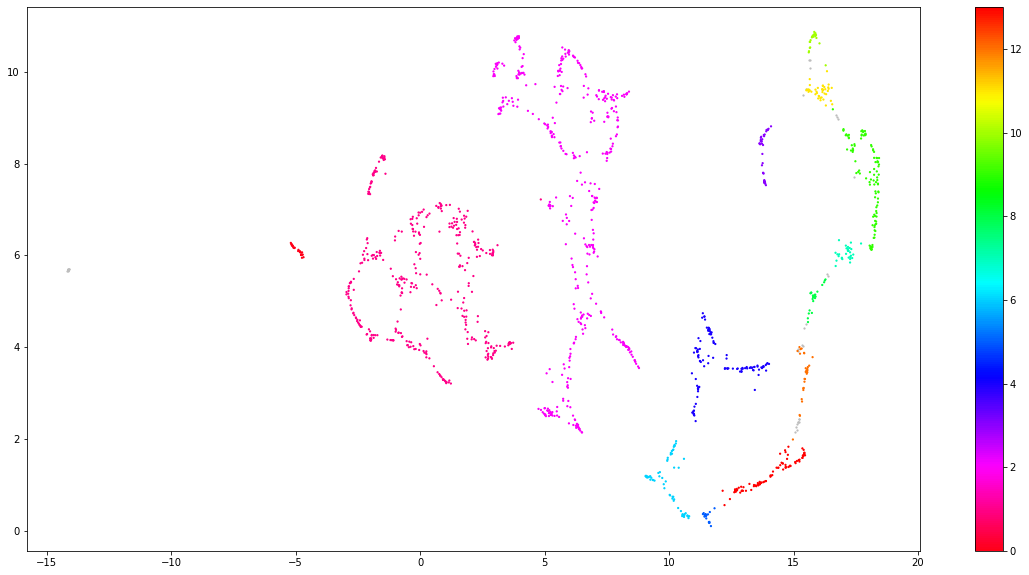

In [24]:
#отрисовка


fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1.5, cmap='hsv_r')
plt.colorbar()

In [25]:
result

x         y  labels
0      1.956922  5.391175       1
1      3.721176  9.344720       2
2     -4.679458  5.957798       0
3     15.849028  5.138894       8
4     -2.416792  4.474778       1
...         ...       ...     ...
1495   9.287872  1.153967       6
1496  -0.056435  6.871342       1
1497  15.541634  3.485158      12
1498  -1.884284  7.740573       1
1499   2.941139  3.864546       1

[1500 rows x 3 columns]

In [ ]:
filename